In [205]:
import torch
from torch.autograd import Variable
from torch import nn, optim
import numpy as np
import matplotlib as mpt
from matplotlib import pyplot as plt
from matplotlib import image as matImg
import os 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as trf
import matplotlib.gridspec as gridspec
%matplotlib inline

### 准备数据

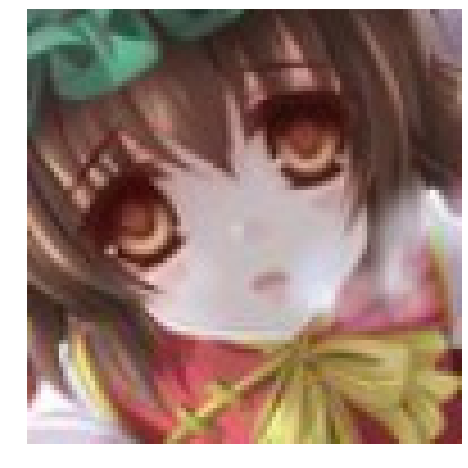

In [286]:
### 读取文件夹下所有文件
from matplotlib import image as matImg 
x = "./faces/0000fdee4208b8b7e12074c920bc6166-0.jpg"
def read_img(path):
    return matImg.imread(path)
plt.axis("off")
x = read_img(x) # 96*96*3
x = trf.ToTensor()(x) # 3*96*96 且归一化
x = x.permute(-2,-1,-3)
x = x.numpy()
x.shape
# x = x.permute(96,96,3)
# x = x.numpy() # 3*96*96
plt.imshow(x)

In [158]:
# 获取图片的路径
def get_img_path(path):
    ls = os.listdir(path)
    ls = [path+"/"+x for x in ls]
    return ls

In [8]:
# 读取所有图片
import os
from matplotlib import image as matImg
path = "./faces"
def load_data(path):
    img_path = get_img_path(path) # 将文件夹下所有图片的路径存入list中
    return [read_img(x) for x in img_path] # 通过路径读取每个图片，以np.array存入list
#     print((img_path[0]))
data = load_data(path)

In [161]:
type(data)

list

###  生成训练数据迭代器

In [162]:
class dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        return img
transforms = trf.Compose([
    trf.ToTensor(),
    trf.Normalize([0.5]*3, [0.5]*3)
])
dset = dataset(data, transforms)
dload = DataLoader(dset, shuffle=True, batch_size=model_param.batch_size)
dload.__iter__().__next__().shape

torch.Size([128, 3, 96, 96])

### 模型超参数

In [308]:
class Param:
    def __init__(self):
        ## 数据处理
        self.path = "./faces"
        self.batch_size = 128
        self.img_size = 96
        ## 随机噪声数据生成
        self.noise = 128
        ## 生成器
        self.G_feature_map = 64
        ## 判别器
        self.D_feature_map = 64    
        self.leak_k = 0.2
        ## 优化
        self.learning_rate = 2e-4
        self.betas=(0.5, 0.999)
        ## 模型训练
        self.epochs = 50000
        ## 画图
        self.interval = 50
        self.deta_inv = 2
model_param = Param()

### 生成器 ：根据随机噪声输入 得到对应输出数据

In [166]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.nz = model_param.noise
        self.fm = model_param.G_feature_map
        self.out = nn.Sequential(
            # 100*1*1 --> (64*8)*4*4
            # ConvTranspose2d 是二维转置卷积
            nn.ConvTranspose2d(self.nz, self.fm * 8, kernel_size=4, bias=False), 
            nn.BatchNorm2d(self.fm * 8), # 批规范化  #如果不好加上0.5试试
            nn.ReLU(True), # True为直接修改覆盖 ，节省内存
 
            # (64*8)*4*4 --> (64*4)*8*8
            nn.ConvTranspose2d(self.fm * 8, self.fm * 4, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(self.fm * 4),
            nn.ReLU(True),
 
            # (64*4)*8*8 --> (64*2)*16*16
            nn.ConvTranspose2d(self.fm * 4, self.fm * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.fm * 2),
            nn.ReLU(True),
 
            # (64*2)*16*16 --> 64*32*32
            nn.ConvTranspose2d(self.fm * 2, self.fm, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.fm),
            nn.ReLU(True),
 
            # 64*32*32 --> 3*96*96
            nn.ConvTranspose2d(self.fm, 3, kernel_size=5, stride=3, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.out(x)
        return x
G = Generator()

### 判别器: 输出输入数据的判别分数

In [168]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fm = model_param.D_feature_map
        self.k = model_param.leak_k
        self.out = nn.Sequential(
            # 3*96*96 --> 64*32*32
            nn.Conv2d(3, self.fm, kernel_size=5, stride=3, padding=1, bias=False),
            nn.LeakyReLU(self.k,True),
 
            # 64*32*32 --> (64*2)*16*16
            nn.Conv2d(self.fm, self.fm * 2, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(self.fm * 2),
            nn.LeakyReLU(self.k,True),
 
            # (64*2)*16*16 --> (64*4)*8*8
            nn.Conv2d(self.fm * 2, self.fm * 4, kernel_size=4, stride=2,padding=1, bias=False), 
            nn.BatchNorm2d(self.fm * 4),
            nn.LeakyReLU(self.k,True),
            # (64*4)*8*8 --> (64*8)*4*4
            nn.Conv2d(self.fm * 4, self.fm * 8, kernel_size=4, stride=2,padding=1, bias=False),
            nn.BatchNorm2d(self.fm * 8),
            nn.LeakyReLU(self.k,True),
 
            # (64*8)*4*4 --> 1 * 1 * 1
            nn.Conv2d(self.fm * 8, 1, kernel_size=4, bias=False), 
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.out(x).view(-1)
D = Discriminator()

### 判别器损失值计算
D（x）为判别器的输出值， 同时将生成器数据和真实数据做判断    
Max-> Loss = ∑x～Pdata(x){㏒D(x)} + ∑x～Pg(x){㏒(1-D(x))}


In [169]:
def Discrim_Loss(real_score, fake_score):
    loss = 0.5*((real_score - 1) ** 2).mean() + 0.5*( fake_score ** 2).mean()
    return loss

### 生成器损失值计算

1. Loss的计算同上，Min -> Loss，目标策略是最小化Loss
2. 但是训练生成器的时候，并不改变判别器的参数，也就是说Loss表达式中的第一项的值并不会随着G的优化而改变 所以：

    Min -> Loss = ∑x～Pg(x){㏒(1-D(x))}

In [176]:
def Gen_Loss(fake_score):
    loss = 0.5*((fake_score - 1) ** 2).mean()
    return loss

### 模型优化算法
1. real_img 和 fake_image 通过判别器后分别得到各自的D（x）
2. 再通过损失值函数算出Loss ,通过Loss去优化模型


In [197]:
G_optim = optim.Adam(G.parameters(), lr=model_param.learning_rate, betas=model_param.betas)

In [198]:
D_optim = optim.Adam(G.parameters(), lr=model_param.learning_rate, betas=model_param.betas)

### 模型的训练

tensor([[ 0.8651, -0.7636,  0.0288,  ..., -0.4936, -0.5494,  0.6853],
        [ 0.9893,  0.9697, -0.7296,  ...,  0.9070, -0.2892,  0.1012],
        [ 0.9630,  0.9220,  0.5579,  ...,  0.0355,  0.6808,  0.4627],
        ...,
        [-0.4533, -0.9661, -0.2543,  ...,  0.5198, -0.4767,  0.7362],
        [-0.1033, -0.4764, -0.8436,  ...,  0.7280, -0.0152,  0.5026],
        [ 0.0920,  0.1465,  0.5176,  ...,  0.6961,  0.9444, -0.7627]])


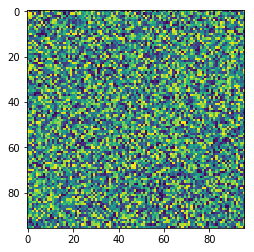

In [193]:
y = (torch.rand(96, 96) - 0.5) / 0.5
plt.imshow(y.numpy())
print(y)


### 画图

In [302]:
# plt.rcParams['figure.figsize'] = (, 10.0) # 设置画图的尺寸
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具 16*3*96*96
    sqrtn = 4
    sqrtimg = 96

    fig = plt.figure(figsize=(sqrtn*4, sqrtn*4))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        # 3*96*96 tensor
        img = img.permute(-2,-1,-3).numpy()
        # 96*96*3 narray
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
    return None

### 训练

the 0 times batch trainning :G loss is 0.19777150452136993, D loss is 0.2023715078830719


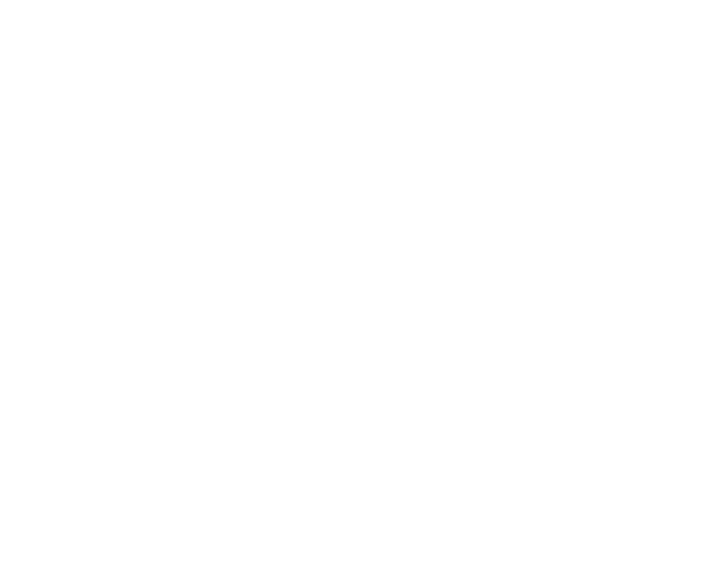

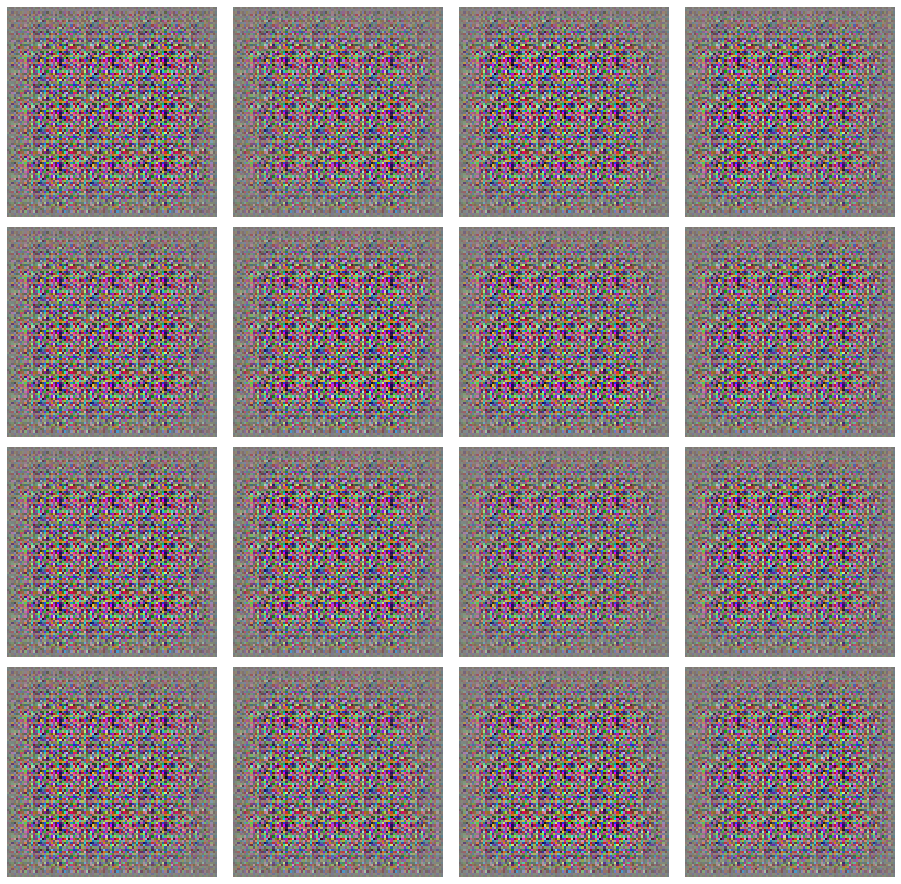

the 1 times batch trainning :G loss is 0.19733558595180511, D loss is 0.20701587200164795
the 2 times batch trainning :G loss is 0.19680990278720856, D loss is 0.2014123797416687
the 3 times batch trainning :G loss is 0.19685032963752747, D loss is 0.2066701352596283
the 4 times batch trainning :G loss is 0.196510910987854, D loss is 0.20627054572105408
the 5 times batch trainning :G loss is 0.19631321728229523, D loss is 0.20303091406822205
the 6 times batch trainning :G loss is 0.19606269896030426, D loss is 0.20775094628334045
the 7 times batch trainning :G loss is 0.19578513503074646, D loss is 0.2045099139213562
the 8 times batch trainning :G loss is 0.19558361172676086, D loss is 0.2031669318675995
the 9 times batch trainning :G loss is 0.19543913006782532, D loss is 0.20213362574577332
the 10 times batch trainning :G loss is 0.19514039158821106, D loss is 0.20791411399841309
the 11 times batch trainning :G loss is 0.19508841633796692, D loss is 0.2059503197669983
the 12 times ba

the 91 times batch trainning :G loss is 0.1900760680437088, D loss is 0.20981542766094208
the 92 times batch trainning :G loss is 0.1899171769618988, D loss is 0.208560049533844
the 93 times batch trainning :G loss is 0.189963236451149, D loss is 0.20769773423671722
the 94 times batch trainning :G loss is 0.19013047218322754, D loss is 0.20569978654384613
the 95 times batch trainning :G loss is 0.1900477409362793, D loss is 0.20907948911190033
the 96 times batch trainning :G loss is 0.1900608241558075, D loss is 0.20762601494789124
the 97 times batch trainning :G loss is 0.19008995592594147, D loss is 0.2090367078781128
the 98 times batch trainning :G loss is 0.1900404393672943, D loss is 0.20615406334400177
the 99 times batch trainning :G loss is 0.19004108011722565, D loss is 0.21237248182296753
the 100 times batch trainning :G loss is 0.18980498611927032, D loss is 0.20634426176548004


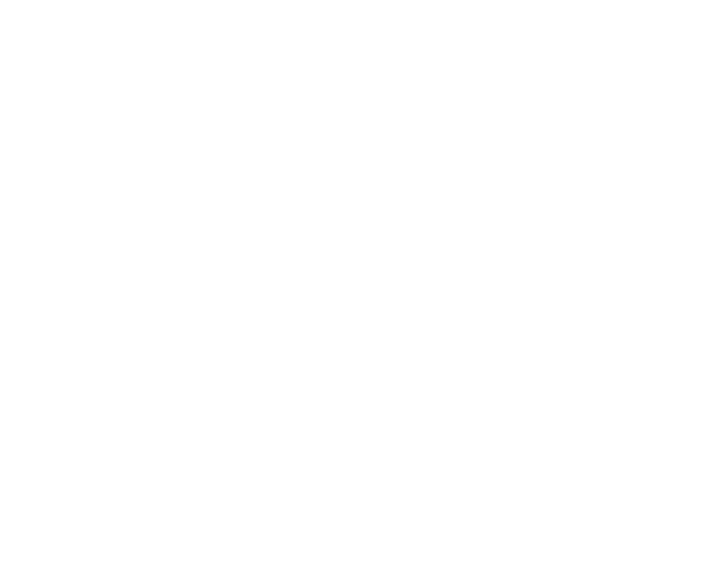

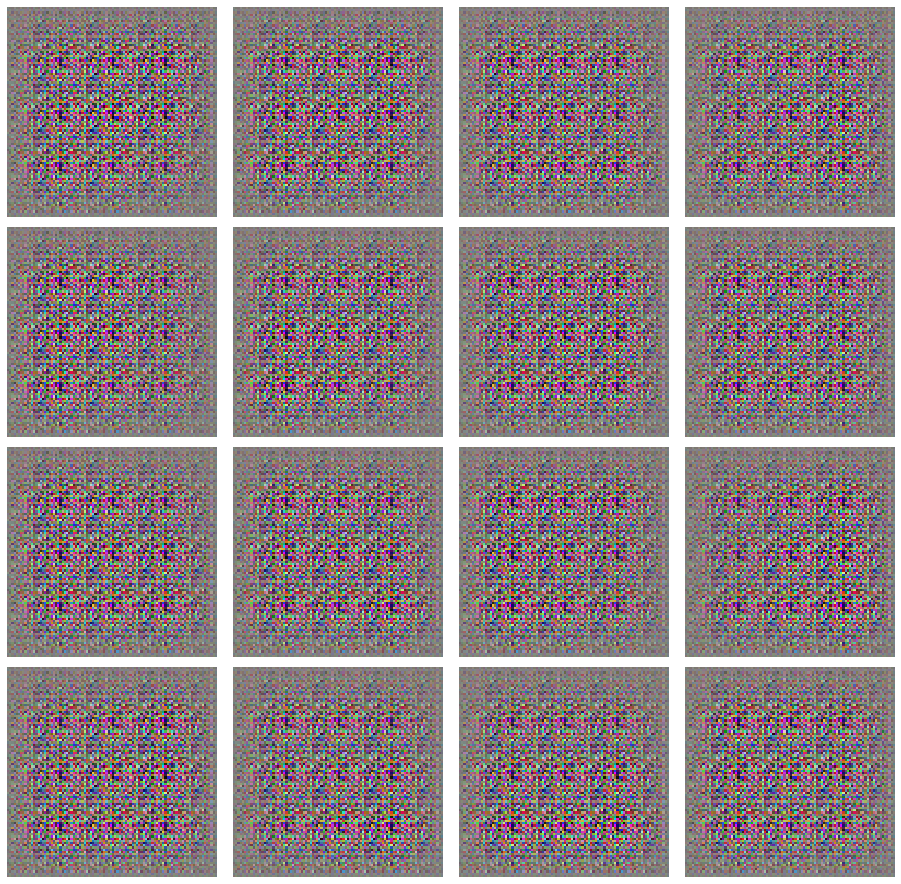

the 101 times batch trainning :G loss is 0.18982216715812683, D loss is 0.20809200406074524
the 102 times batch trainning :G loss is 0.1899285763502121, D loss is 0.20690032839775085
the 103 times batch trainning :G loss is 0.18977472186088562, D loss is 0.20941835641860962
the 104 times batch trainning :G loss is 0.18967533111572266, D loss is 0.2089877426624298
the 105 times batch trainning :G loss is 0.18969739973545074, D loss is 0.20836856961250305
the 106 times batch trainning :G loss is 0.18963661789894104, D loss is 0.21083974838256836
the 107 times batch trainning :G loss is 0.18957513570785522, D loss is 0.20783604681491852
the 108 times batch trainning :G loss is 0.18952232599258423, D loss is 0.2045476883649826
the 109 times batch trainning :G loss is 0.1897166222333908, D loss is 0.20908737182617188
the 110 times batch trainning :G loss is 0.1894938349723816, D loss is 0.20638886094093323
the 111 times batch trainning :G loss is 0.1894417256116867, D loss is 0.209337174892

the 190 times batch trainning :G loss is 0.18862447142601013, D loss is 0.20729990303516388
the 191 times batch trainning :G loss is 0.18881335854530334, D loss is 0.20845995843410492
the 192 times batch trainning :G loss is 0.18862280249595642, D loss is 0.20337362587451935
the 193 times batch trainning :G loss is 0.18877285718917847, D loss is 0.20899353921413422
the 194 times batch trainning :G loss is 0.1885775923728943, D loss is 0.210589200258255
the 195 times batch trainning :G loss is 0.18852630257606506, D loss is 0.21023070812225342
the 196 times batch trainning :G loss is 0.18869245052337646, D loss is 0.20989760756492615
the 197 times batch trainning :G loss is 0.18854641914367676, D loss is 0.20524747669696808
the 198 times batch trainning :G loss is 0.18880502879619598, D loss is 0.21095773577690125
the 199 times batch trainning :G loss is 0.18862943351268768, D loss is 0.20861876010894775
the 200 times batch trainning :G loss is 0.18861687183380127, D loss is 0.208358213

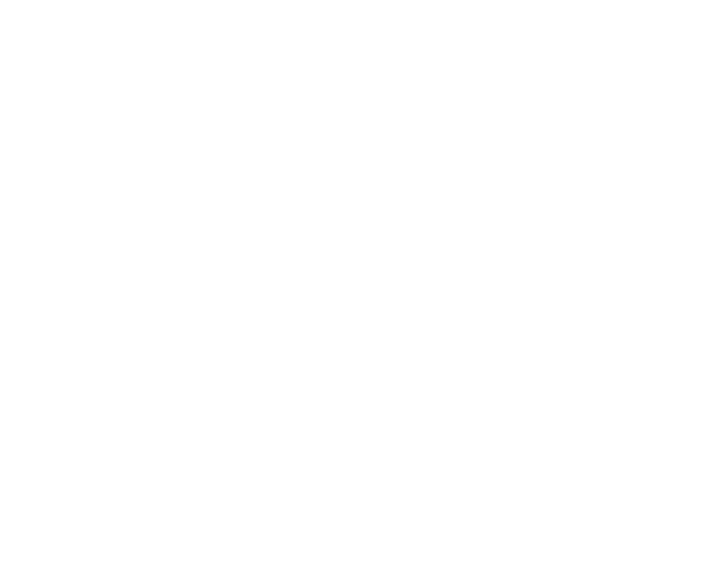

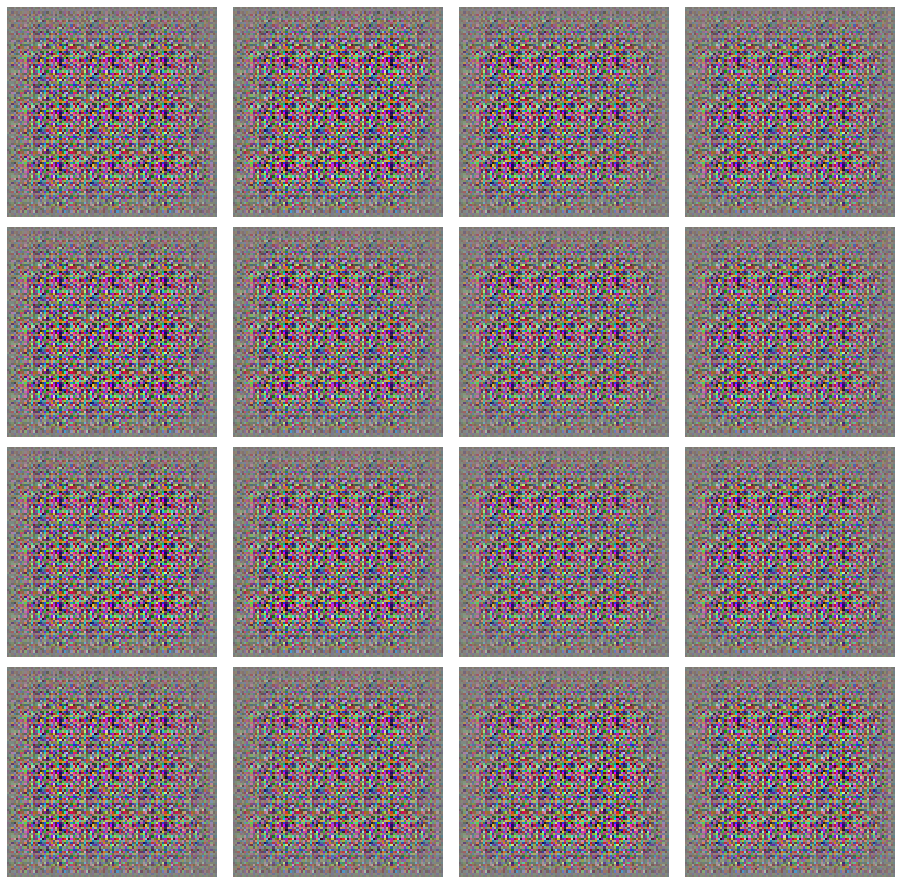

the 201 times batch trainning :G loss is 0.1885276734828949, D loss is 0.20900455117225647
the 202 times batch trainning :G loss is 0.18854810297489166, D loss is 0.2098141610622406
the 203 times batch trainning :G loss is 0.18852275609970093, D loss is 0.20995262265205383
the 204 times batch trainning :G loss is 0.18849405646324158, D loss is 0.20593935251235962


KeyboardInterrupt: 

In [ ]:
cnt = 0
for epoch in range(model_param.epochs):
    for imgs in dload:
        batch = imgs.shape[0]
        real_img = imgs
        sample_nois = (torch.rand(batch, model_param.noise, 1 ,1) - 0.5) / 0.5
        fake_img = G(sample_nois)
        
        ## train D
        real_score = D(real_img)
        fake_score = D(fake_img)
        D_loss = Discrim_Loss(real_score, fake_score)
        
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()
        
        ## train G
        fake_img = G(sample_nois)
        fake_score = D(fake_img)
        G_loss = Gen_Loss(fake_score)
        
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()
        # update
        print("the {} times batch trainning :G loss is {}, D loss is {}".format(cnt, G_loss.data, D_loss.data))
        if cnt % model_param.interval == 0:
            model_param.interval *= model_param.deta_inv
            plt.axis("off")
#             plt.imshow(fake_img[0][0].detach().numpy()
            fake_img = fake_img[:16].detach() 
            show_images(fake_img*0.5+0.5) # [-1,1] -> [0,1]
#             img_ = img_* 20 + 80
#             print(img_.shape)
            plt.show()
        cnt+=1
#         print("the {} times batch trainning :G loss is {}, D loss is {}".format(cnt, G_loss.data, D_loss.data))
torch.save(netD.state_dict(), './netd_%s.pth' )
torch.save(netG.state_dict(), './netg_%s.pth' ) 